In [19]:
import pandas as pd
import numpy as np
import tensorflow as tf
import math
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential 
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop
import os
from sklearn.metrics import mean_squared_error , mean_absolute_error , mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import LSTM , Dense , Dropout , GRU , Concatenate , Input , Conv1D , InputLayer
from tensorflow.keras import models
from tensorflow.keras.callbacks import EarlyStopping

<Strong> Grabbing the data from stored files (originally pulled from Binance) </Strong>

In [20]:
df_eth = pd.read_csv("ETH_1h_data.csv")

In [21]:
df_eth

,date,open,high,low,close,volume
0,2017-08-17 04:00:00.000,301.13,302.57,298.00,301.61,125.66877
1,2017-08-17 05:00:00.000,301.61,303.28,300.00,303.10,377.67246
2,2017-08-17 06:00:00.000,302.40,304.44,301.90,302.68,303.86672
3,2017-08-17 07:00:00.000,302.68,307.96,302.60,307.96,754.74510
4,2017-08-17 08:00:00.000,307.95,309.97,307.00,308.62,150.75029
...,...,...,...,...,...,...
39216,2022-02-11 10:00:00,3102.22,3115.98,3075.24,3106.33,12865.43100
39217,2022-02-11 11:00:00,3106.34,3109.86,3083.93,3088.30,7796.24450
39218,2022-02-11 12:00:00,3088.30,3122.00,3079.16,3102.23,13475.38960
39219,2022-02-11 13:00:00,3102.22,3127.00,3095.00,3121.64,13585.96880


In [22]:
df_headers = df_eth.columns

<Strong> Grabbing the closing price (univariate) </Strong>

In [23]:
# Removing everything but the closing price
eth_data = df_eth.values[:, 4 ,].astype(float)

len(eth_data)

39221

<Strong> Scaling the data  </Strong>

In [24]:
percTrain = 70
percVal = 20

onePercent = len(eth_data) // 100
numberTraining = onePercent * percTrain

scaler = MinMaxScaler()
reshaped_data = eth_data.reshape(-1,1)

#Just scaling on training data otherwise it would be leakage
scaler.fit(reshaped_data[:numberTraining])
scaled_eth = scaler.transform(reshaped_data)

<Strong> Creating Matrix in Sliding window form <Strong>

In [25]:
def sliding_window(elements, window_size):
    
    data = [] 
    targets = []
    
    if len(elements) <= window_size:
        return elements
    
    for i in range(len(elements) - window_size ):
        
        data.append(elements[i:i+window_size])
        targets.append(elements[i+window_size])
        
    return np.array(data) , np.array(targets)

In [26]:
window_length = 24
features = 1


sliding_winda_eth = sliding_window(scaled_eth , window_length)

<Strong> Splitting the data after we create Sliding Window matrix (more data) </Strong>

In [27]:
# Splitting the data after creating the sliding window data

def splitting_train_test(data):
        
    onePercent = len(data[1]) // 100
    
    numberTraining = onePercent * percTrain
    numberValidation = onePercent * percVal
    
    trainingData = data[0][:numberTraining] , data[1][:numberTraining]
    validationData = data[0][numberTraining : numberTraining + numberValidation] , data[1][numberTraining : numberTraining + numberValidation]
    testData = data[0][numberTraining + numberValidation:] , data[1][numberTraining + numberValidation:] 
    
    #Returning tuples of (sliding-window , target_values)
    return trainingData , validationData , testData

In [28]:
#Reshaping the data so we can use min-max a
eth_train , eth_val , eth_test = splitting_train_test(sliding_winda_eth)

print(eth_train[0].shape)

(27370, 24, 1)


<Strong> Creating the model </Strong>

In [29]:
inputs = Input(shape = (window_length , features) )

#From deep learning in python -- better to use recurrent dropout so error propergates correctly
x = LSTM(30 , return_sequences = True )(inputs)
x = Dropout(0.01)(x) 
x = LSTM(50)(x)
x = Dense(128)(x)

y = GRU(30,input_shape=(window_length , features))(inputs)
y = Dropout(0.01)(y)
y = Dense(128)(y)

final = Concatenate()([x,y])
final = Dense(1)(final)

model = tf.keras.Model(inputs=inputs, outputs= final)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 24, 1)]      0           []                               
                                                                                                  
 lstm_2 (LSTM)                  (None, 24, 30)       3840        ['input_2[0][0]']                
                                                                                                  
 dropout_2 (Dropout)            (None, 24, 30)       0           ['lstm_2[0][0]']                 
                                                                                                  
 gru_1 (GRU)                    (None, 30)           2970        ['input_2[0][0]']                
                                                                                            

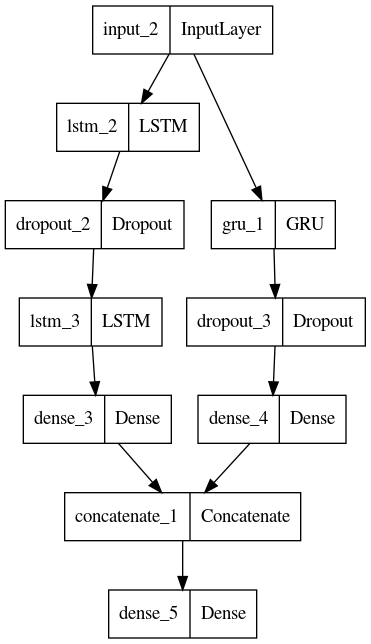

In [30]:
model.summary()
plot_model(model)

In [31]:
model.compile(optimizer='adam' , loss = 'mse')

In [32]:
earlyStopping = EarlyStopping(monitor = 'val_loss' , patience = 30 , mode = 'min' , verbose = 1)

In [33]:
#If use validation in this part , then leakage as we are using the normalized values of the training set which in this case would include validation set.
#Validation set needs to be in a tuple with x , y
history = model.fit(eth_train[0] , eth_train[1] , validation_data = eth_val  , batch_size = 512  , epochs =300 , verbose = 1 , callbacks = [earlyStopping] )



Epoch 1/300
54/54 [==============================] - 5s 26ms/step - loss: 0.0045 - val_loss: 0.0124
Epoch 2/300
54/54 [==============================] - 0s 8ms/step - loss: 5.8258e-05 - val_loss: 0.0127
Epoch 3/300
54/54 [==============================] - 0s 8ms/step - loss: 5.1807e-05 - val_loss: 0.0128
Epoch 4/300
54/54 [==============================] - 0s 8ms/step - loss: 5.1954e-05 - val_loss: 0.0136
Epoch 5/300
54/54 [==============================] - 0s 8ms/step - loss: 4.8964e-05 - val_loss: 0.0132
Epoch 6/300
54/54 [==============================] - 0s 8ms/step - loss: 4.8900e-05 - val_loss: 0.0134
Epoch 7/300
54/54 [==============================] - 0s 8ms/step - loss: 4.6581e-05 - val_loss: 0.0140
Epoch 8/300
54/54 [==============================] - 0s 8ms/step - loss: 4.6676e-05 - val_loss: 0.0132
Epoch 9/300
54/54 [==============================] - 0s 8ms/step - loss: 4.5339e-05 - val_loss: 0.0125
Epoch 10/300
54/54 [==============================] - 0s 8ms/step - loss: 4.

In [34]:
num_epochs = earlyStopping.stopped_epoch

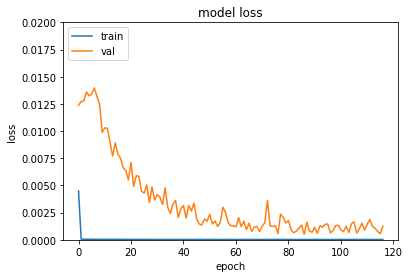

In [37]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.ylim([0,0.02])
plt.show()

<Strong> Testing on the validation data once again , hyper-parameter adjustment. <Strong>

In [38]:
validation_predict = model.predict(eth_val[0])

In [39]:
validation_predict = scaler.inverse_transform(validation_predict)

In [40]:
print(validation_predict)

[[ 345.02826]
 [ 345.53882]
 [ 345.74637]
 ...
 [3157.7375 ]
 [3142.233  ]
 [3160.3848 ]]


In [41]:
validation_actual = scaler.inverse_transform(eth_val[1])
validation_actual

array([[ 353.35],
       [ 353.58],
       [ 354.11],
       ...,
       [3222.24],
       [3240.14],
       [3229.61]])

In [42]:
math.sqrt(mean_squared_error(validation_actual , validation_predict))

47.49070416157596

In [43]:
freshModel = tf.keras.Model(inputs=inputs, outputs= final)
freshModel.compile(optimizer='adam' , loss = 'mse')

<Strong> Only do this last , once perfected hyper-parameters. <Strong>

<Strong> Train on both training and validation , then finnaly test on test set. </Strong>

In [44]:
train_and_val = np.concatenate([eth_train[0] , eth_val[0]] )
train_and_val_targets = np.concatenate([eth_train[1] , eth_val[1] ])

In [45]:
final = freshModel.fit(train_and_val , train_and_val_targets , batch_size = 512  , epochs = num_epochs , verbose = 1 )

Epoch 1/116
69/69 [==============================] - 4s 8ms/step - loss: 4.8444e-04
Epoch 2/116
69/69 [==============================] - 0s 7ms/step - loss: 1.7222e-04
Epoch 3/116
69/69 [==============================] - 0s 7ms/step - loss: 1.6738e-04
Epoch 4/116
69/69 [==============================] - 0s 7ms/step - loss: 1.7401e-04
Epoch 5/116
69/69 [==============================] - 0s 7ms/step - loss: 1.5887e-04
Epoch 6/116
69/69 [==============================] - 0s 7ms/step - loss: 1.6800e-04
Epoch 7/116
69/69 [==============================] - 0s 7ms/step - loss: 1.6630e-04
Epoch 8/116
69/69 [==============================] - 0s 7ms/step - loss: 1.7449e-04
Epoch 9/116
69/69 [==============================] - 0s 7ms/step - loss: 1.7805e-04
Epoch 10/116
69/69 [==============================] - 0s 7ms/step - loss: 1.7143e-04
Epoch 11/116
69/69 [==============================] - 0s 7ms/step - loss: 1.7053e-04
Epoch 12/116
69/69 [==============================] - 0s 7ms/step - loss: 

In [48]:
test_predict = freshModel.predict(eth_test[0])

In [49]:
#Scalling back to the original values 
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(eth_test[1])

In [53]:
math.sqrt(mean_squared_error(test_actual , test_predict , squared=False))

5.6297019569337605